# Example: Find a model for Proteins

In [1]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define color-blind-friendly palette
hex1 = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
hex1_inverted = hex1[::-1]
colors1=[mcolors.to_rgb(i) for i in hex1]

## Load protein data from PDB dataset

In [2]:
jsons = []
with open('../../../supplemental_material/pdb/dataset_4000.txt', 'r') as file:
    for line in file:
        jsons.append(json.loads(line))

In [16]:
np.savez_compressed('../../../supplemental_material/pdb/dataset_4000.npz', data=jsons)

In [3]:
data = jsons[0]
print(str(len(data)) + " entries")

4000 entries


## Generate train and test datasets from entries of the proteins

In [4]:
all_inputs = np.zeros((len(data), 7))
all_targets = np.zeros((len(data), 1))
indices = []
for i in range(len(data)):
    entry = data[i]['entry']
    if 'cell' in entry and 'exptl_crystal' in entry and 'density_percent_sol' in entry['exptl_crystal'][0] \
        and len(entry['cell'].keys()) >= 7 and len(entry['exptl_crystal'][0].keys()) >= 3:
        all_inputs[i, 0] = entry['cell']['angle_alpha']
        all_inputs[i, 1] = entry['cell']['angle_beta']
        all_inputs[i, 2] = entry['cell']['angle_gamma']
        all_inputs[i, 3] = entry['cell']['length_a']
        all_inputs[i, 4] = entry['cell']['length_b']
        all_inputs[i, 5] = entry['cell']['length_c']
        all_inputs[i,6] = entry['exptl_crystal'][0]['density_matthews']
        all_targets[i] = entry['exptl_crystal'][0]['density_percent_sol']
        indices.append(i)
    # else:
    #     print('skipped %d' % i)
all_inputs = all_inputs[indices]
all_targets = all_targets[indices]

print('Number of entries: %d' % len(all_inputs))

Number of entries: 3952


In [5]:
# Set random seed for reproducibility
np.random.seed(42)

# Shuffle the indices
indices = np.random.permutation(len(all_inputs))

# Split the indices for training, testing, and validation sets
train_indices = indices[:4 * len(all_inputs) // 5]
test_indices = indices[4 * len(all_inputs) // 5:]

# Create the training, testing, and validation sets
inputs_training = all_inputs[train_indices]
targets_training = all_targets[train_indices]
inputs_testing = all_inputs[test_indices]
targets_testing = all_targets[test_indices]

In [6]:
input_tensor = torch.tensor(inputs_training, dtype=torch.float32)
target_tensor = torch.tensor(targets_training, dtype=torch.float32)

## Define Model

In [7]:
# Define the model architecture using a sequential container

# define input size, hidden layer size, output size 
D_i, D_k, D_o = 7, 16, 1

# The model consists of:
model = nn.Sequential(
    nn.Linear(D_i, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    # nn.ReLU(),
    # nn.Linear(D_k, D_k),
    nn.ReLU(),
    # nn.Linear(D_k, D_k),
    # nn.ReLU(),
    # nn.Linear(D_k, D_k),
    # nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_o),
)

In [8]:
# Define the loss function and optimizer
# Mean Squared Error (MSE) is used as the loss function
criterion = nn.MSELoss()

In [9]:
# Adam optimizer is used with weight decay (L2 regularization) to prevent overfitting
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
# object that decreases learning rate by half every N epochs 
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

In [10]:

# Train the model
num_epochs = 1000  # Number of epochs to train the model
losses = []  # List to store the loss value for each epoch
# load data
data_loader = DataLoader(TensorDataset(input_tensor,target_tensor), batch_size=64)
# Iterate over the epochs
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize the loss value for this epoch
    # Iterate over the training data in batches
    for i, data in enumerate(data_loader):
        # Get the inputs and targets from the data loader
        inputs, targets = data
        # Clear the gradients of all optimized tensors
        optimizer.zero_grad()  
        
        # Forward pass: compute the model output
        outputs = model(inputs)
        # Compute the loss between the model output and the actual targets
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()        # Compute the gradient of the loss with respect to model parameters
        optimizer.step()       # Update the model parameters based on the computed gradients
        
        # Store the loss value for this epoch
        epoch_loss += loss.item()
        losses.append(loss.item())  # Store the loss value for this epoch
    print(f'Epoch {epoch:5d}, loss {epoch_loss:.3f}')
    # tell scheduler to consider updating learning rate 
    scheduler.step()

Epoch     0, loss 48189.741
Epoch     1, loss 8248.602
Epoch     2, loss 5375.021
Epoch     3, loss 4112.898
Epoch     4, loss 3648.582
Epoch     5, loss 3487.059
Epoch     6, loss 3415.747
Epoch     7, loss 3373.059
Epoch     8, loss 3341.712
Epoch     9, loss 3317.580
Epoch    10, loss 3296.318
Epoch    11, loss 3278.204
Epoch    12, loss 3258.867
Epoch    13, loss 3240.042
Epoch    14, loss 3223.367
Epoch    15, loss 3207.740
Epoch    16, loss 3191.686
Epoch    17, loss 3177.741
Epoch    18, loss 3165.744
Epoch    19, loss 3150.077
Epoch    20, loss 3137.317
Epoch    21, loss 3125.127
Epoch    22, loss 3112.028
Epoch    23, loss 3100.644
Epoch    24, loss 3088.058
Epoch    25, loss 3077.175
Epoch    26, loss 3065.556
Epoch    27, loss 3054.628
Epoch    28, loss 3041.348
Epoch    29, loss 3028.242
Epoch    30, loss 3015.730
Epoch    31, loss 3002.129
Epoch    32, loss 2990.016
Epoch    33, loss 2976.031
Epoch    34, loss 2963.284
Epoch    35, loss 2949.038
Epoch    36, loss 2935.090


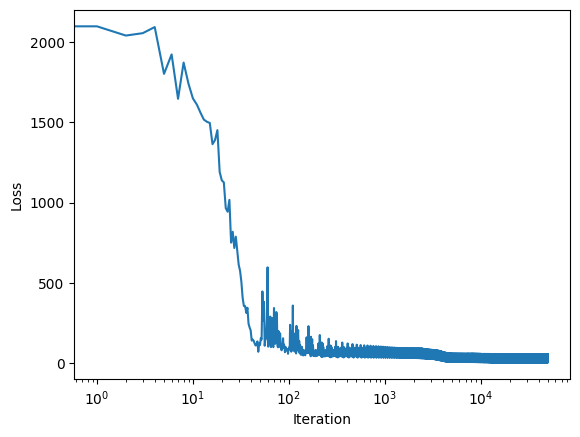

In [11]:
plt.plot(losses)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [12]:
predictions_test = model(torch.tensor(inputs_testing, dtype=torch.float32)).detach().numpy()

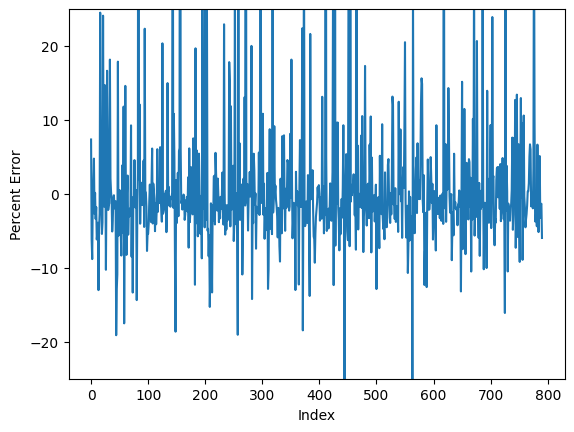

In [13]:
plt.plot(100*(predictions_test/targets_testing-1))
plt.xlabel('Index')
plt.ylabel('Percent Error')
plt.ylim([-25,25])
plt.show()

In [14]:
var_performance = np.sum((predictions_test - targets_testing)**2)/len(predictions_test)
print('Variance of performance: %.3f' % var_performance)

Variance of performance: 16.933


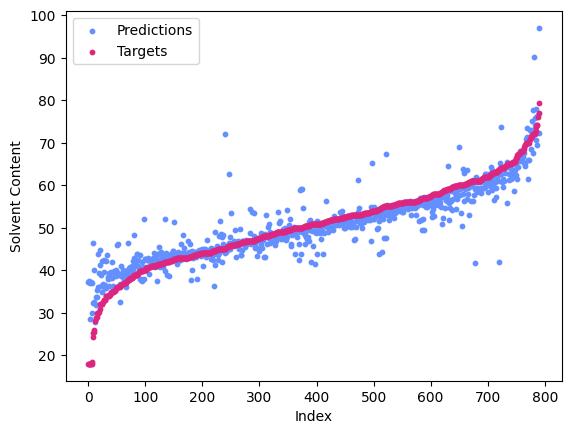

In [15]:
order = np.argsort(targets_testing.flatten())
xvals = np.arange(len(targets_testing))
plt.scatter(xvals,predictions_test[order],label='Predictions',s=10,color=colors1[0])
plt.scatter(xvals,targets_testing[order],label='Targets',color=colors1[2],s=10)
#plt.fill_between(xvals,targets_testing[order].flatten()-np.sqrt(var_performance),targets_testing[order].flatten()+np.sqrt(var_performance),alpha=0.5,color=colors1[2])
plt.xlabel('Index')
plt.ylabel('Solvent Content')
plt.legend()
plt.show()